# Multimodal Emotion Recognition Project
Clean end‑to‑end Colab notebook

In [1]:
!pip -q install torch torchaudio librosa transformers scikit-learn matplotlib seaborn pandas numpy tqdm kaggle

In [2]:
import os

BASE = "/content/project"

folders = [
    "data",
    "models/speech",
    "models/text",
    "models/fusion",
    "utils",
    "results/plots"
]

for f in folders:
    os.makedirs(os.path.join(BASE, f), exist_ok=True)

print("Project structure ready.")


Project structure ready.


In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip -q toronto-emotional-speech-set-tess.zip -d /content/project/data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 90% 384M/428M [00:00<00:00, 534MB/s]
100% 428M/428M [00:00<00:00, 541MB/s]


In [4]:
%%writefile /content/project/utils/data_split.py
import os
from sklearn.model_selection import train_test_split

BASE = "/content/project/data/TESS Toronto emotional speech set data"

EMOTIONS = ["angry","disgust","fear","happy","neutral","sad","surprise"]
LABEL = {e:i for i,e in enumerate(EMOTIONS)}

def collect():
    samples=[]
    for folder in os.listdir(BASE):
        emotion="_".join(folder.split("_")[1:]).lower()
        if emotion in ["pleasant_surprise","pleasant_surprised"]:
            emotion="surprise"

        fp=os.path.join(BASE,folder)
        for f in os.listdir(fp):
            word=f.split("_")[2].replace(".wav","")
            samples.append({
                "audio":os.path.join(fp,f),
                "text":f"Say the word {word}",
                "label":LABEL[emotion]
            })
    return samples

def split(seed=42):
    s=collect()
    y=[x["label"] for x in s]

    trv,te=train_test_split(s,test_size=0.2,stratify=y,random_state=seed)
    ytv=[x["label"] for x in trv]
    tr,va=train_test_split(trv,test_size=0.1,stratify=ytv,random_state=seed)

    return tr,va,te


Writing /content/project/utils/data_split.py


In [5]:
%%writefile /content/project/utils/early_stop.py
import torch

class EarlyStop:
    def __init__(self,patience=3):
        self.best=1e9
        self.p=patience
        self.c=0

    def step(self,loss,model,path):
        if loss<self.best:
            self.best=loss
            self.c=0
            torch.save(model.state_dict(),path)
            return False
        self.c+=1
        return self.c>=self.p


Writing /content/project/utils/early_stop.py


In [6]:
%%writefile /content/project/models/speech/train.py
import sys
sys.path.append("/content/project")

import torch,torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import librosa,numpy as np
from utils.data_split import split
from utils.early_stop import EarlyStop

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

SR=16000; DUR=3; MAX=SR*DUR; MELS=128

class DS(Dataset):
    def __init__(self,s): self.s=s
    def __len__(self): return len(self.s)

    def __getitem__(self,i):
        x=self.s[i]
        a,_=librosa.load(x["audio"],sr=SR)
        a,_=librosa.effects.trim(a)
        a=np.pad(a,(0,max(0,MAX-len(a))))[:MAX]
        m=librosa.feature.melspectrogram(y=a,sr=SR,n_mels=MELS)
        m=librosa.power_to_db(m,ref=np.max)
        return torch.tensor(m,dtype=torch.float32),torch.tensor(x["label"])

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(MELS,128,2,batch_first=True,bidirectional=True)
        self.fc=nn.Linear(256,7)

    def forward(self,x):
        x=x.permute(0,2,1)
        o,_=self.lstm(x)
        return self.fc(o.mean(1))

def run(m,l,c,o=None):
    t=o!=None
    m.train() if t else m.eval()
    tot=0
    with torch.set_grad_enabled(t):
        for x,y in l:
            x,y=x.to(DEVICE),y.to(DEVICE)
            p=m(x); loss=c(p,y)
            if t:
                o.zero_grad(); loss.backward(); o.step()
            tot+=loss.item()
    return tot/len(l)

def train():
    tr,va,_=split()
    tl=DataLoader(DS(tr),16,shuffle=True)
    vl=DataLoader(DS(va),16)

    m=Model().to(DEVICE)
    o=torch.optim.Adam(m.parameters(),1e-4)
    c=nn.CrossEntropyLoss()
    es=EarlyStop()

    for e in range(20):
        tloss=run(m,tl,c,o)
        vloss=run(m,vl,c)
        print(e+1,tloss,vloss)
        if es.step(vloss,m,"/content/project/models/speech/best.pth"):
            break

if __name__=="__main__": train()


Writing /content/project/models/speech/train.py


In [7]:
!python /content/project/models/speech/train.py

1 1.6787980189399114 1.0889678512300764
2 0.7436660431207173 0.4317107115473066
3 0.36510936809437616 0.20284223237207957
4 0.2064998477460846 0.20044067768113955
5 0.17674739499177253 0.13057088160089084
6 0.18464356285357286 0.14441656640597753
7 0.16361152493054903 0.06718201429716178
8 0.09011632146402485 0.06909559334495238
9 0.08289361651986837 0.20658308693340846
10 0.10148077509883377 0.03268443580184664
11 0.08996922904182048 0.04760714527219534
12 0.1555366866615793 0.0647435248164194
13 0.10151542275996199 0.030368931325418607
14 0.07793651967649422 0.030362071402903115
15 0.10346271569234511 0.055355321283319166
16 0.05177236798899396 0.01380220231866198
17 0.03006336071144139 0.02354199459244098
18 0.0855444197520791 0.03296745202637145
19 0.08635914975052907 0.060407908500305245


In [8]:
%%writefile /content/project/models/text/train.py
import sys
sys.path.append("/content/project")

import torch,torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from transformers import BertTokenizer,BertModel
from utils.data_split import split
from utils.early_stop import EarlyStop

tok=BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DS(Dataset):
    def __init__(self,s): self.s=s
    def __len__(self): return len(self.s)

    def __getitem__(self,i):
        x=self.s[i]
        e=tok(x["text"],padding="max_length",truncation=True,
              max_length=16,return_tensors="pt")
        d={k:v.squeeze(0) for k,v in e.items()}
        d["label"]=torch.tensor(x["label"])
        return d

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.b=BertModel.from_pretrained("bert-base-uncased")
        self.fc=nn.Linear(768,7)

    def forward(self,i,m):
        o=self.b(i,attention_mask=m).last_hidden_state[:,0,:]
        return self.fc(o)

def run(m,l,c,o=None):
    t=o!=None
    m.train() if t else m.eval()
    tot=0
    with torch.set_grad_enabled(t):
        for b in l:
            i=b["input_ids"].to(DEVICE)
            a=b["attention_mask"].to(DEVICE)
            y=b["label"].to(DEVICE)
            p=m(i,a); loss=c(p,y)
            if t:
                o.zero_grad(); loss.backward(); o.step()
            tot+=loss.item()
    return tot/len(l)

def train():
    tr,va,_=split()
    tl=DataLoader(DS(tr),8,shuffle=True)
    vl=DataLoader(DS(va),8)

    m=Model().to(DEVICE)
    o=torch.optim.AdamW(m.parameters(),2e-5)
    c=nn.CrossEntropyLoss()
    es=EarlyStop()

    for e in range(10):
        tloss=run(m,tl,c,o)
        vloss=run(m,vl,c)
        print(e+1,tloss,vloss)
        if es.step(vloss,m,"/content/project/models/text/best.pth"):
            break

if __name__=="__main__": train()


Writing /content/project/models/text/train.py


In [9]:
!python /content/project/models/text/train.py

tokenizer_config.json: 100% 48.0/48.0 [00:00<00:00, 219kB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 13.9MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 3.46MB/s]
config.json: 100% 570/570 [00:00<00:00, 3.01MB/s]
model.safetensors: 100% 440M/440M [00:02<00:00, 184MB/s]
Loading weights: 100% 199/199 [00:00<00:00, 989.64it/s, Materializing param=pooler.dense.weight] 
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

In [10]:
%%writefile /content/project/models/fusion/train.py
import sys
sys.path.append("/content/project")

import torch,torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import librosa,numpy as np
from transformers import BertTokenizer,BertModel
from utils.data_split import split
from utils.early_stop import EarlyStop

tok=BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

SR=16000; DUR=3; MAX=SR*DUR; MELS=128

class DS(Dataset):
    def __init__(self,s): self.s=s
    def __len__(self): return len(self.s)

    def __getitem__(self,i):
        x=self.s[i]
        a,_=librosa.load(x["audio"],sr=SR)
        a,_=librosa.effects.trim(a)
        a=np.pad(a,(0,max(0,MAX-len(a))))[:MAX]
        m=librosa.feature.melspectrogram(y=a,sr=SR,n_mels=MELS)
        m=librosa.power_to_db(m,ref=np.max)

        e=tok(x["text"],padding="max_length",
              truncation=True,max_length=16,
              return_tensors="pt")

        d={k:v.squeeze(0) for k,v in e.items()}
        d["mel"]=torch.tensor(m,dtype=torch.float32)
        d["label"]=torch.tensor(x["label"])
        return d

class Speech(nn.Module):
    def __init__(self):
        super().__init__()
        self.l=nn.LSTM(MELS,128,2,batch_first=True,bidirectional=True)
        self.f=nn.Linear(256,128)
    def forward(self,x):
        x=x.permute(0,2,1)
        o,_=self.l(x)
        return self.f(o.mean(1))

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.s=Speech()
        self.t=BertModel.from_pretrained("bert-base-uncased")
        self.tp=nn.Linear(768,128)
        self.c=nn.Linear(256,7)

    def forward(self,m,i,a):
        s=self.s(m)
        t=self.t(i,attention_mask=a).last_hidden_state[:,0,:]
        t=self.tp(t)
        return self.c(torch.cat([s,t],1))

def run(m,l,c,o=None):
    t=o!=None
    m.train() if t else m.eval()
    tot=0
    with torch.set_grad_enabled(t):
        for b in l:
            mel=b["mel"].to(DEVICE)
            i=b["input_ids"].to(DEVICE)
            a=b["attention_mask"].to(DEVICE)
            y=b["label"].to(DEVICE)
            p=m(mel,i,a); loss=c(p,y)
            if t:
                o.zero_grad(); loss.backward(); o.step()
            tot+=loss.item()
    return tot/len(l)

def train():
    tr,va,_=split()
    tl=DataLoader(DS(tr),8,shuffle=True)
    vl=DataLoader(DS(va),8)

    m=Model().to(DEVICE)
    o=torch.optim.Adam(m.parameters(),1e-4)
    c=nn.CrossEntropyLoss()
    es=EarlyStop()

    for e in range(15):
        tloss=run(m,tl,c,o)
        vloss=run(m,vl,c)
        print(e+1,tloss,vloss)
        if es.step(vloss,m,"/content/project/models/fusion/best.pth"):
            break

if __name__=="__main__": train()


Writing /content/project/models/fusion/train.py


In [11]:
!python /content/project/models/fusion/train.py

Loading weights: 100% 199/199 [00:00<00:00, 1027.78it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
1 0.21599608953184787 0.003816223711640175
2 0.0032724110854952227 0.0011308979758593654
3 0.0011839103651240409 0.0005165509054287602
4 0.0006290706931770454 0.0003167411559843

In [12]:
%%writefile /content/project/utils/eval.py
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

EMOTIONS = ["angry","disgust","fear","happy","neutral","sad","surprise"]

def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return acc, f1

def confusion(y_true, y_pred, path, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    plt.imshow(cm)
    plt.title(title)

    plt.xticks(range(len(EMOTIONS)), EMOTIONS, rotation=45)
    plt.yticks(range(len(EMOTIONS)), EMOTIONS)

    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, cm[i,j], ha="center", va="center")

    plt.tight_layout()
    plt.savefig(path)
    plt.close()


Writing /content/project/utils/eval.py


In [13]:
%%writefile /content/project/models/speech/test.py
import sys
sys.path.append("/content/project")

import torch
from torch.utils.data import DataLoader
from train import DS, Model
from utils.data_split import split
from utils.eval import metrics, confusion

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    _,_,te=split()

    loader=DataLoader(DS(te),16)

    model=Model().to(DEVICE)
    model.load_state_dict(torch.load(
        "/content/project/models/speech/best.pth",
        map_location=DEVICE
    ))

    model.eval()

    preds=[]
    labels=[]

    with torch.no_grad():
        for x,y in loader:
            x=x.to(DEVICE)
            out=model(x)
            p=torch.argmax(out,1).cpu().numpy()

            preds.extend(p)
            labels.extend(y.numpy())

    acc,f1=metrics(labels,preds)

    print("Speech Accuracy:",acc)
    print("Speech F1:",f1)

    confusion(labels,preds,
        "/content/project/results/plots/speech_cm.png",
        "Speech Confusion")

    return acc,f1

if __name__=="__main__":
    test()


Writing /content/project/models/speech/test.py


In [14]:
!python /content/project/models/speech/test.py


Speech Accuracy: 0.9821428571428571
Speech F1: 0.9820855033216751


In [15]:
%%writefile /content/project/models/text/test.py
import sys
sys.path.append("/content/project")

import torch
from torch.utils.data import DataLoader
from train import DS, Model
from utils.data_split import split
from utils.eval import metrics, confusion

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    _,_,te=split()

    loader=DataLoader(DS(te),8)

    model=Model().to(DEVICE)
    model.load_state_dict(torch.load(
        "/content/project/models/text/best.pth",
        map_location=DEVICE
    ))

    model.eval()

    preds=[]
    labels=[]

    with torch.no_grad():
        for b in loader:
            i=b["input_ids"].to(DEVICE)
            a=b["attention_mask"].to(DEVICE)

            out=model(i,a)
            p=torch.argmax(out,1).cpu().numpy()

            preds.extend(p)
            labels.extend(b["label"].numpy())

    acc,f1=metrics(labels,preds)

    print("Text Accuracy:",acc)
    print("Text F1:",f1)

    confusion(labels,preds,
        "/content/project/results/plots/text_cm.png",
        "Text Confusion")

    return acc,f1

if __name__=="__main__":
    test()


Writing /content/project/models/text/test.py


In [16]:
!python /content/project/models/text/test.py


Loading weights: 100% 199/199 [00:00<00:00, 940.39it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Text Accuracy: 1.0
Text F1: 1.0


In [17]:
%%writefile /content/project/models/fusion/test.py
import sys
sys.path.append("/content/project")

import torch
from torch.utils.data import DataLoader
from train import DS, Model
from utils.data_split import split
from utils.eval import metrics, confusion

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test():
    _,_,te=split()

    loader=DataLoader(DS(te),8)

    model=Model().to(DEVICE)
    model.load_state_dict(torch.load(
        "/content/project/models/fusion/best.pth",
        map_location=DEVICE
    ))

    model.eval()

    preds=[]
    labels=[]

    with torch.no_grad():
        for b in loader:
            mel=b["mel"].to(DEVICE)
            i=b["input_ids"].to(DEVICE)
            a=b["attention_mask"].to(DEVICE)

            out=model(mel,i,a)
            p=torch.argmax(out,1).cpu().numpy()

            preds.extend(p)
            labels.extend(b["label"].numpy())

    acc,f1=metrics(labels,preds)

    print("Fusion Accuracy:",acc)
    print("Fusion F1:",f1)

    confusion(labels,preds,
        "/content/project/results/plots/fusion_cm.png",
        "Fusion Confusion")

    return acc,f1

if __name__=="__main__":
    test()


Writing /content/project/models/fusion/test.py


In [18]:
!python /content/project/models/fusion/test.py


Loading weights: 100% 199/199 [00:00<00:00, 934.57it/s, Materializing param=pooler.dense.weight]
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Fusion Accuracy: 1.0
Fusion F1: 1.0


In [19]:
import pandas as pd
import subprocess

speech = subprocess.check_output(
    ["python","/content/project/models/speech/test.py"]
).decode()

text = subprocess.check_output(
    ["python","/content/project/models/text/test.py"]
).decode()

fusion = subprocess.check_output(
    ["python","/content/project/models/fusion/test.py"]
).decode()

def parse(out):
    lines = out.strip().split("\n")
    acc=float(lines[0].split(":")[1])
    f1=float(lines[1].split(":")[1])
    return acc,f1

sa,sf=parse(speech)
ta,tf=parse(text)
fa,ff=parse(fusion)

df=pd.DataFrame({
    "Model":["Speech","Text","Fusion"],
    "Accuracy":[sa,ta,fa],
    "F1":[sf,tf,ff]
})

df
df.to_csv("/content/project/results/accuracy_table.csv",index=False)


In [20]:
# Quick error finder
import torch
from torch.utils.data import DataLoader
from project.models.speech.train import DS, Model
from project.utils.data_split import split

_,_,te = split()
loader = DataLoader(DS(te),1)

model = Model()
model.load_state_dict(torch.load("/content/project/models/speech/best.pth"))
model.eval()

errors = []

for i,(x,y) in enumerate(loader):
    p = torch.argmax(model(x),1)
    if p != y:
        errors.append((i,int(y),int(p)))
    if len(errors)==5:
        break

errors


[(5, 6, 3), (47, 6, 3), (49, 6, 4), (335, 3, 6), (367, 6, 1)]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


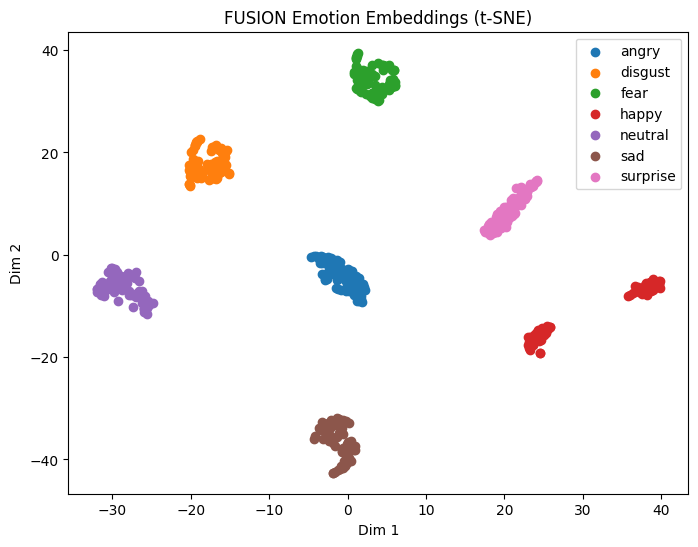

In [25]:
# ===== t-SNE Visualization for Emotion Embeddings =====

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

from project.utils.data_split import split

EMOTIONS = ["angry","disgust","fear","happy","neutral","sad","surprise"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- SELECT MODEL TYPE --------
MODE = "fusion"   # change to: "text" or "fusion"


# ===== SPEECH =====
if MODE == "speech":
    from project.models.speech.train import DS, Model

    _,_,test = split()
    loader = DataLoader(DS(test), batch_size=16)

    model = Model()
    model.load_state_dict(torch.load("/content/project/models/speech/best.pth"))
    model.to(DEVICE)
    model.eval()

    embeddings = []
    labels = []

    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)

            # extract LSTM features BEFORE classifier
            feat,_ = model.lstm(x.permute(0,2,1))
            feat = feat.mean(1)

            embeddings.append(feat.cpu().numpy())
            labels.extend(y.numpy())


# ===== TEXT =====
elif MODE == "text":
    from project.models.text.train import DS, Model

    _,_,test = split()
    loader = DataLoader(DS(test), batch_size=8)

    model = Model()
    model.load_state_dict(torch.load("/content/project/models/text/best.pth"))
    model.to(DEVICE)
    model.eval()

    embeddings = []
    labels = []

    with torch.no_grad():
        for b in loader:
            ids = b["input_ids"].to(DEVICE)
            mask = b["attention_mask"].to(DEVICE)

            cls = model.b(ids, attention_mask=mask).last_hidden_state[:,0,:]

            embeddings.append(cls.cpu().numpy())
            labels.extend(b["label"].numpy())


# ===== FUSION =====
elif MODE == "fusion":
    from project.models.fusion.train import DS, Model

    _,_,test = split()
    loader = DataLoader(DS(test), batch_size=8)

    model = Model()
    model.load_state_dict(torch.load("/content/project/models/fusion/best.pth"))
    model.to(DEVICE)
    model.eval()

    embeddings = []
    labels = []

    with torch.no_grad():
        for b in loader:
            mel = b["mel"].to(DEVICE)
            ids = b["input_ids"].to(DEVICE)
            mask = b["attention_mask"].to(DEVICE)

            s = model.s(mel)
            t = model.t(ids, attention_mask=mask).last_hidden_state[:,0,:]
            t = model.tp(t)

            fused = torch.cat([s,t],1)

            embeddings.append(fused.cpu().numpy())
            labels.extend(b["label"].numpy())


# ===== Run t-SNE =====

embeddings = np.concatenate(embeddings)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))

for i,emotion in enumerate(EMOTIONS):
    idx = labels == i
    plt.scatter(reduced[idx,0], reduced[idx,1], label=emotion)

plt.legend()
plt.title(f"{MODE.upper()} Emotion Embeddings (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [26]:
%%writefile /content/project/README.md
# Multimodal Emotion Recognition

Speech, Text and Fusion emotion classifiers using TESS dataset.

## Structure

- Speech pipeline: LSTM on mel spectrogram
- Text pipeline: BERT classifier
- Fusion: Concatenated speech + text embeddings

## Results

See results/accuracy_table.csv
See plots in results/plots


Writing /content/project/README.md


In [27]:
%%writefile /content/project/requirements.txt
torch
torchaudio
librosa
transformers
scikit-learn
matplotlib
pandas
numpy
tqdm


Writing /content/project/requirements.txt


In [28]:
!zip -r /content/final_project.zip /content/project


Streaming output truncated to the last 5000 lines.
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_hate_happy.wav (deflated 24%)
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_boat_happy.wav (deflated 25%)
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_peg_happy.wav (deflated 25%)
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_rose_happy.wav (deflated 20%)
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_mood_happy.wav (deflated 19%)
  adding: content/project/data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_bite_happy.wav (deflated 25%)
  adding: content/project/data/t

In [29]:
from google.colab import files
files.download("/content/final_project.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>